In [1]:
!pwd
%cd /media/laptq/data/workspace/hello-gen-ai

/media/laptq/data/workspace/hello-gen-ai/notebooks


/media/laptq/data/workspace/hello-gen-ai


/media/laptq/data/workspace/hello-gen-ai/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
BATCHSIZE = 128
STEP_SIZE = 200
LR = 0.001
EPOCHS = 15
DEVICE = 'cuda:0'
N_HIDDENS = 8
N_LABELS = 10

In [4]:
device = torch.device(DEVICE)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCHSIZE,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.MNIST(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)
testloader = DataLoader(
    testset, 
    batch_size=BATCHSIZE,
    shuffle=False, 
    num_workers=2
)

classes = [str(i) for i in range(10)]


# print image shape
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


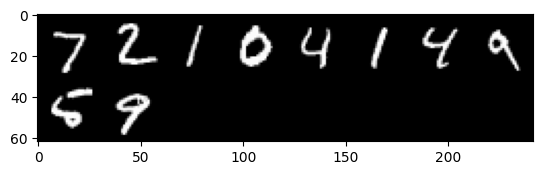

7     2     1     0     4     1     4     9     5     9    


In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

n_show = 10
imshow(torchvision.utils.make_grid(images[:n_show]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(min(n_show, BATCHSIZE))))

## AE

In [6]:
class Encoder(nn.Module):

    def __init__(
            self,
            **kwargs
    ):
        super(Encoder, self).__init__()

        n_hiddens = kwargs['n_hiddens']

        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, n_hiddens)

    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x
        

class Decoder(nn.Module):

    def __init__(
            self,
            **kwargs
    ):
        super(Decoder, self).__init__()

        n_hiddens = kwargs['n_hiddens']

        self.fc1 = nn.Linear(n_hiddens, 256)
        self.fc2 = nn.Linear(256, 28*28)

    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = torch.reshape(x, (-1, 1, 28, 28))

        return x
    

class AE(nn.Module):

        def __init__(
                self,
                **kwargs
        ):
            super(AE, self).__init__()

            self.n_hiddens = kwargs['n_hiddens']

            self.encoder = Encoder(n_hiddens=self.n_hiddens)
            self.decoder = Decoder(n_hiddens=self.n_hiddens)

        
        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)

            return encoded, decoded
        

net_ae = AE(
    n_hiddens=N_HIDDENS
)

net_ae.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(     # use Adam instead of SGD, unsure why using SGD stuck at local minimum
    net_ae.parameters(), 
    lr=LR,
)

net_ae(torch.randn(1, 1, 28, 28).to(device))

net_ae

AE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=8, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=784, bias=True)
  )
)

In [ ]:
net_ae.train()

for epoch in range(EPOCHS):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        _, decoded = net_ae(inputs)
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % STEP_SIZE == (STEP_SIZE - 1):
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / STEP_SIZE:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.072
[1,   400] loss: 0.056
[2,   200] loss: 0.053
[2,   400] loss: 0.050
[3,   200] loss: 0.044
[3,   400] loss: 0.043
[4,   200] loss: 0.042
[4,   400] loss: 0.041
[5,   200] loss: 0.040
[5,   400] loss: 0.040
[6,   200] loss: 0.039
[6,   400] loss: 0.039
[7,   200] loss: 0.039
[7,   400] loss: 0.038
[8,   200] loss: 0.038
[8,   400] loss: 0.038
[9,   200] loss: 0.037
[9,   400] loss: 0.037
[10,   200] loss: 0.037
[10,   400] loss: 0.037
[11,   200] loss: 0.037
[11,   400] loss: 0.037
[12,   200] loss: 0.036
[12,   400] loss: 0.036
[13,   200] loss: 0.036
[13,   400] loss: 0.036
[14,   200] loss: 0.036
[14,   400] loss: 0.036
[15,   200] loss: 0.036
[15,   400] loss: 0.035
Finished Training


In [ ]:
mae = 0
with torch.no_grad():
    for data in testloader:
        images, _ = data
        images = images.to(device)
        _, decoded = net_ae(images)
        mae += torch.mean(torch.abs(decoded - images)).item()

print(f'MAE of the network on the test images: {mae / len(testloader)}')

MAE of the network on the test images: 0.08605544382258307


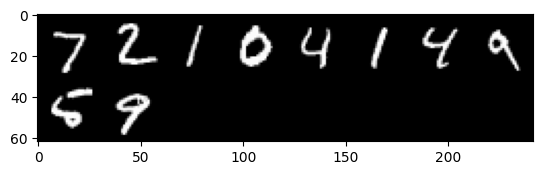

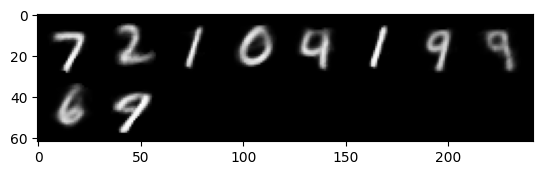

In [ ]:
dataiter = iter(testloader)
images, _ = next(dataiter)
with torch.no_grad():
    images = images.to(device)
    _, decoded = net_ae(images)

n_show = 10
imshow(torchvision.utils.make_grid(images.cpu()[:n_show]))
imshow(torchvision.utils.make_grid(decoded.cpu()[:n_show]))

## VAE

In [7]:
class VAE(AE):

    def __init__(
            self,
            **kwargs
    ):
        super(VAE, self).__init__(**kwargs)

        self.mu = nn.Linear(self.n_hiddens, self.n_hiddens)
        self.logvar = nn.Linear(self.n_hiddens, self.n_hiddens)


    def forward(self, x):
        encoded = self.encoder(x)
        
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)

        # reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        encoded = mu + eps * std

        decoded = self.decoder(encoded)

        return encoded, decoded, mu, logvar
    

    def generate(self, noise):
        with torch.no_grad():
            decoded = self.decoder(noise)

        return decoded


net_vae = VAE(
    n_hiddens=N_HIDDENS
)

net_vae.to(device)

def loss_fn(
        **kwargs
):
    inputs = kwargs['inputs']
    decoded = kwargs['decoded']
    mu = kwargs['mu']
    logvar = kwargs['logvar']

    loss_rec = nn.MSELoss(
        reduction='sum'     # sum instead of mean, because KLD is also sum
    )(decoded, inputs)
    loss_kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return loss_rec + 3 * loss_kl

optimizer = optim.Adam(
    net_vae.parameters(), 
    lr=LR,
)

In [ ]:
net_vae.train()

for epoch in range(EPOCHS):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        _, decoded, mu, logvar = net_vae(inputs)
        loss = loss_fn(
            inputs=inputs,
            decoded=decoded,
            mu=mu,
            logvar=logvar
        )
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % STEP_SIZE == (STEP_SIZE - 1):
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / STEP_SIZE:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 8008.243
[1,   400] loss: 6749.681
[2,   200] loss: 6598.039
[2,   400] loss: 6429.199
[3,   200] loss: 6237.516
[3,   400] loss: 6123.113
[4,   200] loss: 5990.368
[4,   400] loss: 5929.056
[5,   200] loss: 5893.107
[5,   400] loss: 5877.112
[6,   200] loss: 5841.112
[6,   400] loss: 5834.831
[7,   200] loss: 5809.632
[7,   400] loss: 5799.352
[8,   200] loss: 5781.180
[8,   400] loss: 5775.725
[9,   200] loss: 5765.325
[9,   400] loss: 5747.142
[10,   200] loss: 5728.871
[10,   400] loss: 5726.201
[11,   200] loss: 5710.750
[11,   400] loss: 5706.423
[12,   200] loss: 5697.962
[12,   400] loss: 5691.334
[13,   200] loss: 5685.859
[13,   400] loss: 5676.266
[14,   200] loss: 5670.330
[14,   400] loss: 5681.805
[15,   200] loss: 5660.902
[15,   400] loss: 5651.720
Finished Training


cuda:0


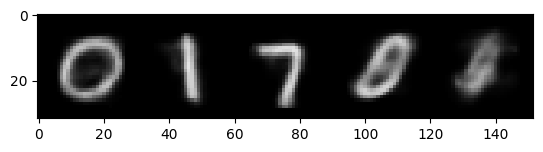

In [ ]:
with torch.no_grad():
    noise = torch.randn(5, N_HIDDENS).to(device)
    img_gen = net_vae.generate(noise)
    img_gen = img_gen.cpu()
    imshow(torchvision.utils.make_grid(img_gen))

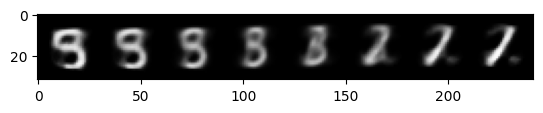

In [ ]:
# gradually change one components of the noise
component = [3, 4, 5]
num = 8
with torch.no_grad():
    noise = torch.randn(N_HIDDENS)
    noise = noise.repeat(num, 1)
    noise[:, component] = torch.linspace(-2, 2, num * len(component)).reshape(num, len(component))
    noise = noise.to(device)
    img_gen = net_vae.generate(noise)
    img_gen = img_gen.cpu()
    imshow(torchvision.utils.make_grid(img_gen))

## Conditional VAE

In [14]:
class CVAE(VAE):

    def __init__(
            self,
            **kwargs
    ):
        super(CVAE, self).__init__(**kwargs)

        self.n_labels = kwargs['n_labels']

        self.label_projector = nn.Linear(self.n_labels, self.n_hiddens)


    def forward(self, x, y):
        encoded = self.encoder(x)
        
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)

        # reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        encoded = mu + eps * std

        # condition on label
        encoded = self.condition_on_label(encoded, y)

        decoded = self.decoder(encoded)

        return encoded, decoded, mu, logvar
    

    def condition_on_label(self, z, y):
        return z + F.relu(self.label_projector(y))
    

    def generate(self, noise, labels):
        with torch.no_grad():
            onehot = F.one_hot(labels, num_classes=self.n_labels).float()
            encoded = self.condition_on_label(noise, onehot)
            decoded = self.decoder(encoded)

        return decoded


net_cvae = CVAE(
    n_hiddens=N_HIDDENS,
    n_labels=N_LABELS,
)

net_cvae.to(device)

optimizer = optim.Adam(
    net_cvae.parameters(), 
    lr=LR,
)

In [15]:
net_cvae.train()

for epoch in range(EPOCHS):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        onehot = F.one_hot(labels, num_classes=N_LABELS).float().to(device)
        optimizer.zero_grad()
        _, decoded, mu, logvar = net_cvae(inputs, onehot)
        loss = loss_fn(
            inputs=inputs,
            decoded=decoded,
            mu=mu,
            logvar=logvar
        )
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % STEP_SIZE == (STEP_SIZE - 1):
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / STEP_SIZE:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 7929.086
[1,   400] loss: 6404.109
[2,   200] loss: 6120.277
[2,   400] loss: 5904.438
[3,   200] loss: 5678.802
[3,   400] loss: 5558.793
[4,   200] loss: 5411.544
[4,   400] loss: 5330.599
[5,   200] loss: 5254.808
[5,   400] loss: 5219.366
[6,   200] loss: 5180.385
[6,   400] loss: 5108.056
[7,   200] loss: 5076.609
[7,   400] loss: 5046.404
[8,   200] loss: 5033.535
[8,   400] loss: 5010.136
[9,   200] loss: 4975.664
[9,   400] loss: 4964.091
[10,   200] loss: 4938.617
[10,   400] loss: 4931.064
[11,   200] loss: 4898.101
[11,   400] loss: 4903.840
[12,   200] loss: 4898.116
[12,   400] loss: 4869.162
[13,   200] loss: 4860.305
[13,   400] loss: 4862.512
[14,   200] loss: 4865.483
[14,   400] loss: 4838.331
[15,   200] loss: 4820.403
[15,   400] loss: 4846.268
Finished Training


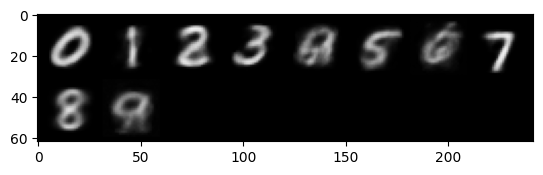

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


In [32]:
n_examples = 10
with torch.no_grad():
    noise = torch.randn(n_examples, N_HIDDENS).to(device)
    labels = torch.arange(n_examples).to(device)
    img_gen = net_cvae.generate(noise, labels)
    img_gen = img_gen.cpu()
    imshow(torchvision.utils.make_grid(img_gen))
    print(labels)

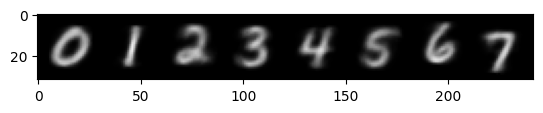

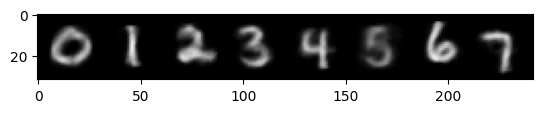

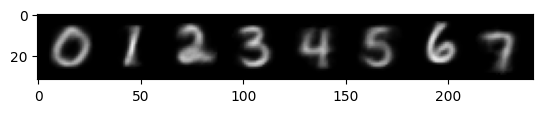

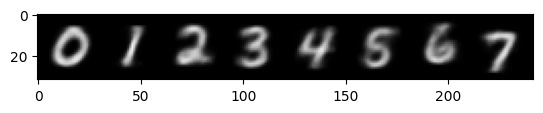

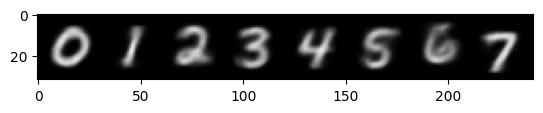

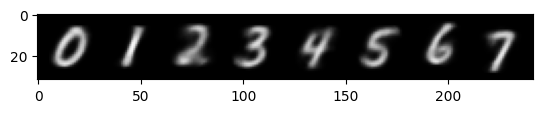

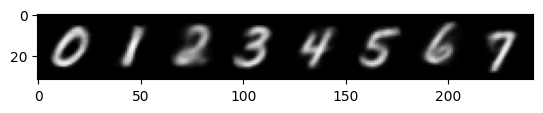

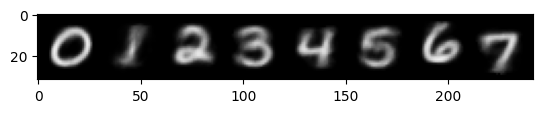

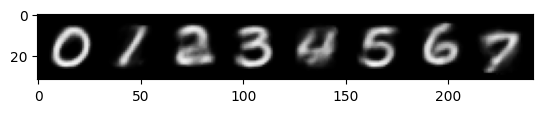

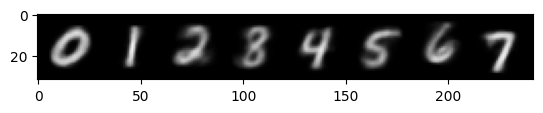

In [52]:
# same noise but different conditional labels
n_examples = 8
n_iters = 10
for _ in range(n_iters):
    with torch.no_grad():
        noise = torch.randn(N_HIDDENS)
        noise = noise.repeat(n_examples, 1)
        noise = noise.to(device)
        labels = torch.arange(n_examples).to(device)
        img_gen = net_cvae.generate(noise, labels)
        img_gen = img_gen.cpu()
        imshow(torchvision.utils.make_grid(img_gen))

# References

1. https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95